In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../datasets/positional_data/liverpool_2019.csv', index_col=('play', 'frame'))

data.head()

Unnamed: 0 bgcolor        dx        dy  \
play                          frame                                           
Liverpool [3] - 0 Bournemouth 0               0     NaN  0.000000  0.000000   
                              1               1     NaN  0.185745  1.217580   
                              2               2     NaN  0.178659  1.171133   
                              3               3     NaN  0.171573  1.124685   
                              4               4     NaN  0.164488  1.078238   

                                    edgecolor  player  player_num team  \
play                          frame                                      
Liverpool [3] - 0 Bournemouth 0           NaN       0         NaN  NaN   
                              1           NaN       0         NaN  NaN   
                              2           NaN       0         NaN  NaN   
                              3           NaN       0         NaN  NaN   
                              4           NaN       0         NaN  NaN   

                                             x          y    z  
play                          frame                             
Liverpool [3] - 0 Bournemouth 0      46.394558  11.134454  0.0  
                              1      46.580302  12.352034  0.0  
                              2      46.758961  13.523166  0.0  
                              3      46.930535  14.647852  0.0  
                              4      47.095022  15.726090  0.0

In [3]:
#list of goals included in the dataset
data.index.get_level_values('play').unique()

Index(['Liverpool [3] - 0 Bournemouth', 'Bayern 0 - [1] Liverpool',
       'Fulham 0 - [1] Liverpool', 'Southampton 1 - [2] Liverpool',
       'Liverpool [2] - 0 Porto', 'Porto 0 - [2] Liverpool',
       'Liverpool [4] - 0 Barcelona', 'Liverpool [1] - 0 Wolves',
       'Liverpool [3] - 0 Norwich', 'Liverpool [2] - 1 Chelsea',
       'Liverpool [2] - 1 Newcastle', 'Liverpool [2] - 0 Salzburg',
       'Genk 0 - [3] Liverpool', 'Liverpool [2] - 0 Man City',
       'Liverpool [1] - 0 Everton', 'Liverpool [2] - 0 Everton',
       'Bournemouth 0 - 3 Liverpool', 'Liverpool [1] - 0 Watford',
       'Leicester 0 - [3] Liverpool'],
      dtype='object', name='play')

In [4]:
play = 'Leicester 0 - [3] Liverpool'

df = data.loc[play]
df.head()

,Unnamed: 0,bgcolor,dx,dy,edgecolor,player,player_num,team,x,y,z
frame,,,,,,,,,,,
0,0,NaN,0.0,0.0,NaN,0,NaN,NaN,80.255236,39.047528,0.0
1,1,NaN,0.0,0.0,NaN,0,NaN,NaN,80.255236,39.047528,0.0
2,2,NaN,0.0,0.0,NaN,0,NaN,NaN,80.255236,39.047528,0.0
3,3,NaN,0.0,0.0,NaN,0,NaN,NaN,80.255236,39.047528,0.0
4,4,NaN,0.0,0.0,NaN,0,NaN,NaN,80.255236,39.047528,0.0


# Defining Possession

Possession is harder to define in football than most other sports. You can't grab the ball, and there's no reserved area for each team. So touches are usually used as the main criterion. If you touch the ball two times in a row, you have control of the ball.

But there are a lot of gray areas:
* If a player has the ball near him for a while but doesn't touch it, does he not have control?
* In contested possession, even if a player touches the ball twice, does he have control?

For this notebook, we'll define blocks of possession as the period between the first touch and the last touch by a player.

Due to how the data was collected, I know that the ball is recorded with the exact same coordinates as the player touching it. I also know that in close control (subjectively determined by me watching the video) the ball has have the same the players coordinates for a longer period than just the moments he touches the ball.

In [5]:
def get_possession_df(df):
    #get a DataFrame for Ball position
    dfBall = df.reset_index()[df.reset_index().player==0].set_index('frame')[['x', 'y']]

    #temporary DataFrame with all player's position relative to the ball 
    dfTemp = df.reset_index().set_index('frame').join(dfBall, rsuffix='_ball')
    dfTemp = dfTemp[dfTemp.player!=0]
    dfTemp['dif_x'] = dfTemp['x'].sub(dfTemp['x_ball'])
    dfTemp['dif_y'] = (dfTemp['y'] - dfTemp['y_ball'])

    #DataFrame with all the frames where a player touches or has close control of the ball.
    dfPossession = dfTemp[((dfTemp[['dif_x', 'dif_y']]==0).sum(axis=1))==2].reset_index()
    dfPossession.player_num = dfPossession.player_num.astype('Int64')
    return dfPossession

dfPossession = get_possession_df(df)

dfPossession.head()

,frame,Unnamed: 0,bgcolor,dx,dy,edgecolor,player,player_num,team,x,y,z,x_ball,y_ball,dif_x,dif_y
0,0,1250,red,0.0,0.0,white,2937,7,attack,80.255236,39.047528,0.0,80.255236,39.047528,0.0,0.0
1,1,1251,red,0.0,0.0,white,2937,7,attack,80.255236,39.047528,0.0,80.255236,39.047528,0.0,0.0
2,2,1252,red,0.0,0.0,white,2937,7,attack,80.255236,39.047528,0.0,80.255236,39.047528,0.0,0.0
3,3,1253,red,0.0,0.0,white,2937,7,attack,80.255236,39.047528,0.0,80.255236,39.047528,0.0,0.0
4,4,1254,red,0.0,0.0,white,2937,7,attack,80.255236,39.047528,0.0,80.255236,39.047528,0.0,0.0


# Defining Events

Most basic events, like passes, shots, or interceptions, bookend possession blocks. 

Let's focus on passes. A pass has two properties:
1. The players from a sequence of possession blocks belong to the same team.
2. There's an intention to get the ball to a teammate. This distinguishes a pass from a shot that hits a teammate or a tackle that allows a teammate to get the ball.

Due to the characteristics of the dataset we're working with (only sequence that leads to a goal), the second requirement is almost always true. We'll assume it always is (there are a couple of interceptions which may be mislabeled due to this assumption).

In [6]:
def get_passes_df(dfPossession):
    #determining the start end enf of each possession block
    poss_start = dfPossession[dfPossession['player']!=dfPossession.shift(1)['player']]
    poss_end = dfPossession[dfPossession['player']!=dfPossession.shift(-1)['player']]

    #relevant columns to keep in the final DataFrame
    columns = ['team', 'x', 'y', 'frame', 'player_num']
    
    #list of all changes in possession
    dfPasses = pd.concat([poss_end.reset_index()[columns].rename(lambda x: 'from_{}'.format(x), axis='columns'),
                          poss_start.iloc[1:].reset_index()[columns].rename(lambda x: 'to_{}'.format(x), axis='columns')
                         ], axis='columns')

    #keep all changes in possession from players of the same team
    dfPasses = dfPasses[dfPasses['from_team']==dfPasses['to_team']]
    return dfPasses

dfPasses = get_passes_df(dfPossession)

dfPasses

,from_team,from_x,from_y,from_frame,from_player_num,to_team,to_x,to_y,to_frame,to_player_num
0,attack,83.3973,36.103011,24,7,attack,92.139400,16.669171,60.0,66
1,attack,92.1394,16.669171,60,66,attack,91.973975,52.775476,78.0,9


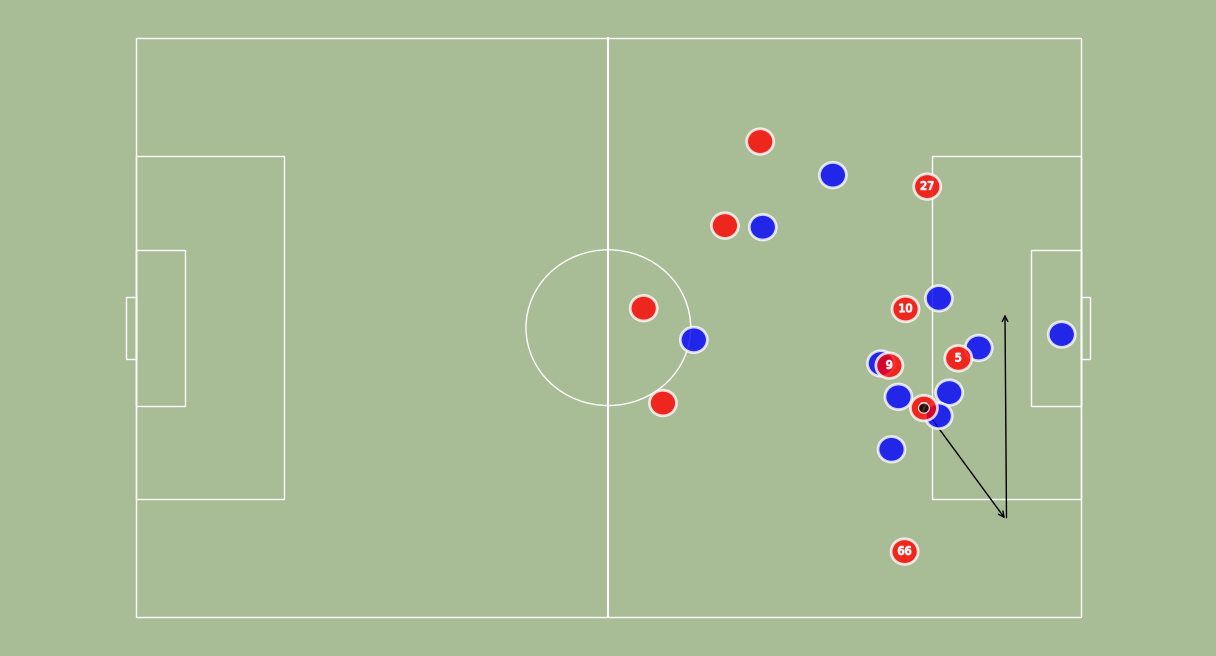

In [7]:
import sys, os
sys.path.insert(0, os.path.abspath('../scripts/'))
import footyviz
from matplotlib import pyplot as plt

fig, ax, dfFrame = footyviz.draw_frame(df, dfPasses.loc[0]['from_frame']/20)

for ix,event in dfPasses.iterrows():
    plt.annotate('', event[['to_x', 'to_y']], event[['from_x', 'from_y']], arrowprops={'arrowstyle':'->'}, annotation_clip=False)

# Compiling and saving info

In [8]:
def get_passes_from_play(data, play):
    df = data.loc[play]
    dfPossession = get_possession_df(df)
    dfPasses = get_passes_df(dfPossession)
    dfPasses['play'] = play
    return dfPasses

dfFull = pd.concat([get_passes_from_play(data, play) for play in data.index.get_level_values('play').unique()])

dfFull.head(8)

,from_team,from_x,from_y,from_frame,from_player_num,to_team,to_x,to_y,to_frame,to_player_num,play
0,attack,46.394558,11.134454,0,10,attack,48.844160,27.191910,22.0,8,Liverpool [3] - 0 Bournemouth
1,attack,51.813185,28.611598,42,8,attack,85.565258,30.767056,108.0,9,Liverpool [3] - 0 Bournemouth
2,attack,85.565258,30.767056,108,9,attack,86.219036,33.236389,118.0,11,Liverpool [3] - 0 Bournemouth
0,attack,36.054422,68.277311,16,4,attack,82.955888,73.003584,78.0,10,Bayern 0 - [1] Liverpool
0,attack,47.429230,15.842044,14,26,attack,28.497923,7.131785,42.0,10,Fulham 0 - [1] Liverpool
1,attack,10.715205,23.615313,118,10,attack,0.677320,36.776241,154.0,9,Fulham 0 - [1] Liverpool
2,attack,0.677320,36.776241,154,9,attack,6.826108,44.926209,168.0,10,Fulham 0 - [1] Liverpool
0,defense,85.342088,42.882899,22,NaN,defense,78.387274,41.050413,48.0,NaN,Southampton 1 - [2] Liverpool


In [9]:
dfFull.to_csv('../datasets/positional_data/liverpool_2019_passes.csv')